In [224]:
import numpy as np
import random
import matplotlib.pyplot as plt

#I/ Applying PSO to the Corrupted Blood Pandemic World of Warcraft disease


##1) Simulation Parameters

These parameters define various aspects of the simulation, including duration, damage range, trigger period, range, initial population, basic reproduction number, and health classes.

In [225]:
# Simulation Parameters
DURATION = 4  # Duration of the effect in seconds
DAMAGE_RANGE = (263, 337)  # Damage range every 2 seconds
TRIGGER_PERIOD = 2  # Damage trigger period in seconds
RANGE = 100  # Range in yards

# Player Behavior Data
INITIAL_POPULATION = 5000  # Initial number of players affected
R0 = 10  # Basic reproduction number per hour

# Health Classes (HP)
HEALTH_POINTS = {
    'low': 80,
    'medium': 4500,
    'high': 9000
}

##2) Problem Definition and Fitness Evaluation

This section defines the problem function and the fitness evaluation function. The problem function simulates the number of infected players based on the input solution, while the assess_fitness function evaluates the fitness of the solution by calling the problem function.

In the problem function, the code models the spread of infection by incorporating various factors:

- **Effectiveness of Quarantine Measures**: The effectiveness of quarantine measures is determined by the solution input, reflecting the degree to which quarantine measures can control the spread of the disease.

- **Effect of Player Behaviors**: Factors such as the effect of player familiars on disease transmission, player teleportation, and player avoidance of urban areas influence disease spread dynamics.

- **Intensity of Quarantine Efforts**: The intensity of quarantine efforts is considered, affecting the overall effectiveness of quarantine measures in controlling the spread of the disease.

- **Immunity in PvP Areas**: Immunity in Player versus Player (PvP) areas is taken into account, as it impacts the likelihood of disease transmission in PvP scenarios.

- **NPC Asymptomatic Effect**: The effect of asymptomatic Non-Player Characters (NPCs) on disease transmission is accounted for, reflecting the role of NPCs in spreading the disease silently.

The problem function calculates the number of infected players based on these factors and returns the result.

The assess_fitness function iterates over different player classes and their percentages among the total population, simulating the infection dynamics for each class. It evaluates the fitness of the solution by calculating the total number of infected players across all player classes.

In [226]:
# Define the problem function
def problem(solution):
    """Simulation of the number of infected players."""
    initial_infected = solution[0]  # Initial number of infected players
    quarantine_effectiveness = solution[1]  # Effectiveness of quarantine measures
    familiar_effect = solution[2]  # Effect of player familiars on disease transmission
    teleportation_effect = solution[3]  # Effect of player teleportation on disease spread
    urban_avoidance_effect = solution[4]  # Effect of player avoidance of urban areas on disease spread
    quarantine_effort = solution[5]  # Intensity of quarantine efforts
    pvp_immunity = solution[6]  # Immunity in PvP areas
    npc_asymptomatic = solution[7]  # Asymptomatic NPCs effect

    # Ensure solutions are within realistic domains
    initial_infected = max(0, min(INITIAL_POPULATION, initial_infected))
    quarantine_effectiveness = max(0, min(1, quarantine_effectiveness))
    familiar_effect = max(0, min(1, familiar_effect))  # Ensure familiar effect is between 0 and 1
    teleportation_effect = max(0, min(1, teleportation_effect))  # Ensure teleportation effect is between 0 and 1
    urban_avoidance_effect = max(0, min(1, urban_avoidance_effect))  # Ensure urban avoidance effect is between 0 and 1
    quarantine_effort = max(0, min(1, quarantine_effort))  # Ensure quarantine effort is between 0 and 1
    pvp_immunity = max(0, min(1, pvp_immunity))  # Ensure PvP immunity is between 0 and 1
    npc_asymptomatic = max(0, min(1, npc_asymptomatic))  # Ensure NPC asymptomatic effect is between 0 and 1

    # Apply effects of player behaviors
    transmission_rate = (R0 / 100) * (1 - quarantine_effectiveness) * (1 - familiar_effect) \
                        * (1 - teleportation_effect) * (1 - urban_avoidance_effect)

    # Adjust for quarantine efforts
    transmission_rate *= (1 - quarantine_effort)

    # Adjust for PvP immunity
    transmission_rate *= (1 - pvp_immunity)

    # Adjust for NPC asymptomatic effect
    transmission_rate *= (1 - npc_asymptomatic)

    # Simplified simulation of infection evolution
    infected = initial_infected * transmission_rate

    return infected

# assess_fitness function
def assess_fitness(solution):
    total_infected = 0
    for player_class, percentage in classes_percentage.items():
        num_players = INITIAL_POPULATION * percentage / 100
        for _ in range(int(num_players)):
            level = survival_threshold_levels[player_class]
            hp_with_equip = calculate_hp_with_equip(player_class, level)
            # Concatenate solution with player information
            player_solution = list(solution)  # Convert solution to a list to allow appending
            player_solution.extend([level, hp_with_equip])
            total_infected += problem(player_solution)
    return total_infected


# Calculate HP with equipment based on player class and level
def calculate_hp_with_equip(player_class, level):
    if player_class == "Warrior":
        return 150.51 * level + 120
    elif player_class == "Paladin":
        return 142.03 * level + 120
    elif player_class == "Hunter":
        return 100.00 * level + 100
    elif player_class == "Rogue":
        return 83.05 * level + 100
    elif player_class == "Priest":
        return 74.92 * level + 80
    elif player_class == "Warlock" or player_class == "Mage":
        return 71.53 * level + 80
    elif player_class == "Shaman":
        return 133.56 * level + 120
    elif player_class == "Druid":
        return 125.08 * level + 120

##3) Particle Class

This class represents a particle in the particle swarm optimization (PSO) algorithm. It contains methods for initializing a particle, assessing its fitness, and updating its position and velocity.

In [227]:
class Particle:
    def __init__(self, problem, velocity, position, index):
        self.velocity = velocity
        self.position = position
        self.fittest_position = position
        self.problem = problem
        self.id = index
        self.previous_fitness = float('inf')

    def assess_fitness(self):
        """Determines the fitness of the particle using the given problem."""
        return assess_fitness(self.position)

    def update(self, fittest_informant, global_fittest, follow_current, follow_personal_best, follow_social_best, follow_global_best, scale_update_step):
        """Updates the velocity and position of the particle using the PSO algorithm."""
        self.position += self.velocity * scale_update_step
        cognitive = random.uniform(0, follow_personal_best)
        social = random.uniform(0, follow_social_best)
        glob = random.uniform(0, follow_global_best)
        self.velocity = (follow_current * self.velocity
                        + cognitive * (self.fittest_position - self.position)
                        + social * (fittest_informant.fittest_position - self.position)
                        + glob * (global_fittest.fittest_position - self.position))
        current_fitness = self.assess_fitness()
        if (current_fitness < self.previous_fitness):
            self.fittest_position = self.position
        self.previous_fitness = current_fitness

##4) PSO (Particle Swarm Optimization) Class

This class represents the PSO algorithm. It initializes a swarm of particles, updates the swarm, and finds the global fittest particle.
The PSO class mirrors the Particle Swarm Optimization algorithm, mirroring the process of optimizing solutions akin to managing a guild in World of Warcraft (WoW). Acting as the guild leader, it oversees a swarm of particles—guild members—seeking to minimize infections within the WoW community.


In [228]:
class PSO:
    def __init__(self, problem, swarm_size, vector_length, num_informants=2):
        self.swarm_size = swarm_size
        self.num_informants = num_informants
        self.problem = problem
        self.swarm = [Particle(self.problem, np.zeros(vector_length), np.random.rand(vector_length), i)
                      for i, x in enumerate(range(swarm_size))]
        self.global_fittest = np.random.choice(self.swarm, 1)[0]

    def update_swarm(self, follow_current, follow_personal_best, follow_social_best, follow_global_best, scale_update_step):
        """Updates each particle in the swarm."""
        for particle in self.swarm:
            informants = np.random.choice(self.swarm, self.num_informants)
            if particle not in informants:
                np.append(informants, particle)
            fittest_informant = find_current_best(informants)
            particle.update(fittest_informant,
                            self.global_fittest,
                            follow_current,
                            follow_personal_best,
                            follow_social_best,
                            follow_global_best,
                            scale_update_step)

    def update_global_fittest(self):
        fittest = find_current_best(self.swarm)
        global_fittest_fitness = self.global_fittest.assess_fitness()
        if (fittest.assess_fitness() < global_fittest_fitness):
            self.global_fittest = fittest

    def improve(self, follow_current, follow_personal_best, follow_social_best, follow_global_best, scale_update_step):
        """Improves the population for one iteration."""
        self.update_swarm(follow_current, follow_personal_best, follow_social_best, follow_global_best, scale_update_step)
        self.update_global_fittest()

def find_current_best(swarm):
    """Evaluates a given swarm and returns the fittest particle."""
    fitnesses = [x.assess_fitness() for x in swarm]
    best_value = min(fitnesses)
    best_index = fitnesses.index(best_value)
    return swarm[best_index]

##5) Particle Swarm Optimization (PSO) Parameters

This code segment orchestrates the execution of the PSO algorithm to optimize infection control strategies within the World of Warcraft (WoW) community. Here's a breakdown:

1. **PSO Parameters:** Defines parameters such as the swarm size, vector length, number of informants, and the number of iterations for the PSO algorithm.
2. **Dictionaries:** Contains data related to player classes, including their percentages among all players, survival threshold levels, and initial population by class.
3. **PSO Execution:** Initiates the PSO algorithm, iteratively improving the swarm's strategies to minimize infections.
4. **Display Results:** Prints the optimal position and minimal number of infections achieved by the best particle found by the PSO algorithm.
5. **Population Simulation:** Simulates infections for each player class, updating the population counts accordingly.
6. **Calculate Survival Metrics:** Calculates survival rates, average survival levels, percentage of remaining players by class, and identifies classes with the lowest remaining players.
7. **Print Results:** Displays the percentage of remaining players by class, average survival level, and advises on classes to avoid to resist the virus effectively.

This segment integrates PSO optimization techniques with WoW-themed data and strategies to mitigate infections and optimize player survival within the virtual world.

In [229]:
# PSO Parameters
swarm_size = 100
vector_length = 8
num_informants = 6
num_iterations = 50

# PSO Coefficients
follow_current = 0.7
follow_personal_best = 2.0
follow_social_best = 0.9
follow_global_best = 0.0
scale_update_step = 0.7

# Dictionary containing the percentage of each player class among all players
classes_percentage = {
    'Paladin': 0.25,
    'Hunter': 0.25,
    'Mage': 0.25,
    'Warrior': 0.25,
    'Priest': 0.175,
    'Rogue': 0.175,
    'Druid': 0.125,
    'Shaman': 0.125,
    'Warlock': 0.125
}

# Dictionary containing survival threshold levels for each player class
survival_threshold_levels = {
    'Warrior': 19,
    'Paladin': 20,
    'Hunter': 28,
    'Rogue': 34,
    'Priest': 38,
    'Warlock': 40,
    'Mage': 40,
    'Shaman': 21,
    'Druid': 23
}

# Track initial population by class
initial_population_by_class = {
    'Paladin': int(INITIAL_POPULATION * classes_percentage['Paladin']),
    'Hunter': int(INITIAL_POPULATION * classes_percentage['Hunter']),
    'Mage': int(INITIAL_POPULATION * classes_percentage['Mage']),
    'Warrior': int(INITIAL_POPULATION * classes_percentage['Warrior']),
    'Priest': int(INITIAL_POPULATION * classes_percentage['Priest']),
    'Rogue': int(INITIAL_POPULATION * classes_percentage['Rogue']),
    'Druid': int(INITIAL_POPULATION * classes_percentage['Druid']),
    'Shaman': int(INITIAL_POPULATION * classes_percentage['Shaman']),
    'Warlock': int(INITIAL_POPULATION * classes_percentage['Warlock'])
}

# Run PSO
pso = PSO(assess_fitness, swarm_size, vector_length, num_informants)
for _ in range(num_iterations):
    pso.improve(follow_current, follow_personal_best, follow_social_best, follow_global_best, scale_update_step)

# Display the position and fitness of the best particle
print(f"Optimal position: {pso.global_fittest.position}")
print(f"Minimal number of infections: {assess_fitness(pso.global_fittest.position)}")

# Calculate the percentage of survivors for each class
final_population_by_class = initial_population_by_class.copy()

# Simulate infections for each class
for particle in pso.swarm:
    infected_players = assess_fitness(particle.position)
    for player_class, percentage in classes_percentage.items():
        num_infected_in_class = infected_players * percentage
        final_population_by_class[player_class] -= num_infected_in_class
        final_population_by_class[player_class] = max(0, final_population_by_class[player_class])  # Ensure no negative population

# Calculate the survival rate for each class
survival_rate_by_class = {}
total_surviving_players = sum(final_population_by_class.values())
total_initial_players = sum(initial_population_by_class.values())

for class_name in initial_population_by_class:
    if initial_population_by_class[class_name] > 0:
        survival_rate = (final_population_by_class[class_name] / initial_population_by_class[class_name]) * 100
        survival_rate_by_class[class_name] = survival_rate

# Calculate the average survival level
average_survival_level = sum([survival_threshold_levels[class_name] * (final_population_by_class[class_name] / total_surviving_players)
                              for class_name in final_population_by_class]) if total_surviving_players > 0 else 0

# Calculate the percentage of remaining players by class
percentage_remaining_by_class = {
    class_name: (final_population_by_class[class_name] / total_surviving_players) * 100
    for class_name in final_population_by_class if total_surviving_players > 0
}

# Find the minimum remaining players
min_remaining_players = min(final_population_by_class.values())

# Find all classes with the minimum remaining players
classes_with_lowest_remaining = [class_name for class_name, remaining in final_population_by_class.items() if remaining == min_remaining_players]

# Print the percentage of remaining players by class
print("\nPercentage of remaining players by class:")
for class_name, percentage in percentage_remaining_by_class.items():
    print(f"{class_name}: {percentage:.2f}%")

# Print the average survival level
print(f"\nAverage survival level: {average_survival_level:.2f}")

# Conclude with advice
classes_to_avoid = ", ".join(classes_with_lowest_remaining)
print("\nTo conclude, to resist the virus, one needs to be on average level "
      f"{average_survival_level:.2f} and avoid choosing these classes: {classes_to_avoid}")

Optimal position: [0.28310013 0.56340775 0.73298826 1.1266275  0.87363575 1.18829493
 0.58170003 0.96220079]
Minimal number of infections: 0.0

Percentage of remaining players by class:
Paladin: 14.49%
Hunter: 14.49%
Mage: 14.49%
Warrior: 14.49%
Priest: 10.14%
Rogue: 10.14%
Druid: 7.25%
Shaman: 7.25%
Warlock: 7.25%

Average survival level: 28.90

To conclude, to resist the virus, one needs to be on average level 28.90 and avoid choosing these classes: Druid, Shaman, Warlock


##6) PSO Simulation Data Collection

This section implements a function to run one iteration of the PSO algorithm and collect simulation data. The PSO algorithm is executed for a specified number of iterations, and data regarding the optimal position and minimal number of infections are stored for each iteration. Additionally, it identifies the iteration where the number of infections drops to 0.

In [230]:
def run_pso_iteration(pso_instance):
    """Function to run one iteration of the PSO algorithm and return simulation data."""
    iteration_data = {
        'global_fittest_position': pso_instance.global_fittest.position.copy(),  # Make a copy of the position
        'global_fittest_fitness': pso_instance.global_fittest.assess_fitness()
        # Add any other data you want to collect
    }
    return iteration_data

# Initialize a list to store simulation data
simulation_data = []

# Initialize PSO
pso = PSO(problem, swarm_size, vector_length, num_informants)

# Run iterations of the PSO algorithm
for _ in range(num_iterations):
    # Run one iteration of the PSO algorithm and get simulation data
    iteration_data = run_pso_iteration(pso)

    # Add this iteration's data to the simulation_data list
    simulation_data.append(iteration_data)

    # Improve the PSO for the next iteration
    pso.improve(follow_current, follow_personal_best, follow_social_best, follow_global_best, scale_update_step)

# Display simulation data
for i, data in enumerate(simulation_data):
    print(f"Iteration {i+1}: Optimal position: {data['global_fittest_position']}, Minimal number of infections: {data['global_fittest_fitness']}")

# Find the iteration where the number of infections drops close to 0
for i, data in enumerate(simulation_data):
    if data['global_fittest_fitness'] <= 0:  # You can adjust this threshold as needed
        print(f"The number of infections drops close to 0 after {i+1} iterations.")
        break


Iteration 1: Optimal position: [0.28369422 0.78165879 0.60525805 0.51457356 0.64825731 0.84568558
 0.53459093 0.44621638], Minimal number of infections: 0.001361580460492823
Iteration 2: Optimal position: [0.16229635 0.69928461 0.66261453 0.99818547 0.01962598 0.99254038
 0.37520945 0.79124488], Minimal number of infections: 2.3369458025629572e-07
Iteration 3: Optimal position: [0.73733214 0.98379183 0.96503727 0.67752901 0.56236019 0.97180068
 0.56420892 0.72919689], Minimal number of infections: 1.6091418676585886e-06
Iteration 4: Optimal position: [0.38748463 0.58488801 1.00699252 0.41513287 0.71400473 0.44510443
 0.4132108  0.29456233], Minimal number of infections: 0.0
Iteration 5: Optimal position: [0.37427632 0.71067155 1.28513699 0.22000108 0.92784373 0.34154929
 0.39354949 0.3728351 ], Minimal number of infections: 0.0
Iteration 6: Optimal position: [0.42801011 0.75040506 1.34405478 0.18606637 1.0551624  0.33622076
 0.47462959 0.44807139], Minimal number of infections: 0.0
Ite

##7) PSO Visualization: Optimal Positions and Fitness

This code segment utilizes Matplotlib to visualize the optimal positions and fitness values of the best particle over iterations in the Particle Swarm Optimization (PSO) algorithm. Three plots are generated:

1. **Optimal Positions over Iterations**: Shows how the optimal position evolves over iterations.
2. **Minimal Fitness of Best Particle over Iterations**: Illustrates the minimal fitness value of the best particle over iterations.
3. **Optimal Positions Scatter Plot**: Displays the optimal positions as scatter points in the XY plane over iterations.

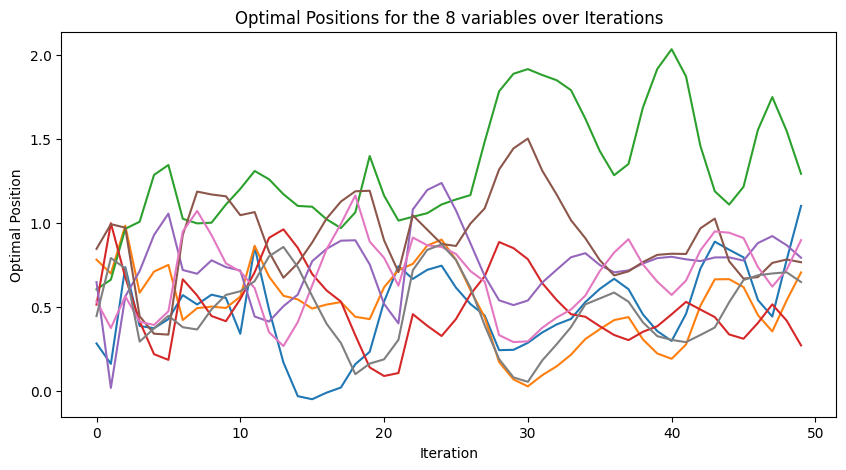

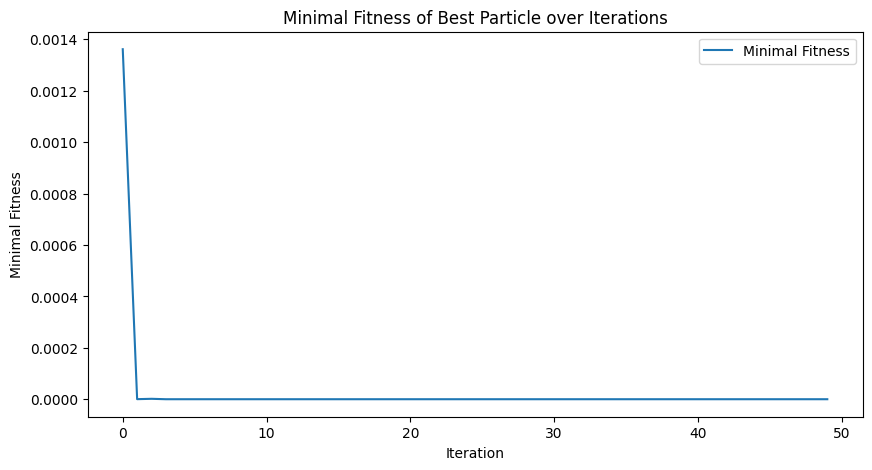

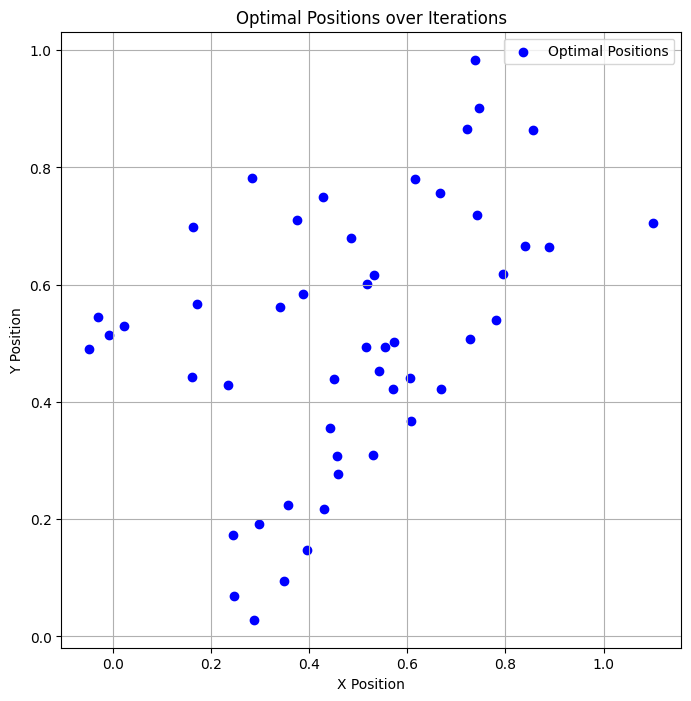

In [231]:
import matplotlib.pyplot as plt

# Extract position and fitness data for each iteration
positions = [data['global_fittest_position'] for data in simulation_data]
fitnesses = [data['global_fittest_fitness'] for data in simulation_data]

# Create a plot to display optimal positions over iterations
plt.figure(figsize=(10, 5))
plt.plot(positions, label='Optimal Position')
plt.title("Optimal Positions for the 8 variables over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Optimal Position")
plt.show()

# Create a plot to display fitness values over iterations
plt.figure(figsize=(10, 5))
plt.plot(fitnesses, label='Minimal Fitness')
plt.title("Minimal Fitness of Best Particle over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Minimal Fitness")
plt.legend()
plt.show()

# Extract optimal positions for x and y coordinates
optimal_x_positions = [data['global_fittest_position'][0] for data in simulation_data]
optimal_y_positions = [data['global_fittest_position'][1] for data in simulation_data]

# Create a scatter plot to display optimal positions
plt.figure(figsize=(8, 8))
plt.scatter(optimal_x_positions, optimal_y_positions, label='Optimal Positions', color='blue')
plt.title("Optimal Positions over Iterations")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)
plt.show()

##8) PSO Particle Movement Visualization

This code segment utilizes Matplotlib to create visualizations depicting the movement of particles on a map throughout the iterations of the Particle Swarm Optimization (PSO) algorithm. Here's a summary:

1. **Plotting Function:** Defines a function `plot_particle_movement(iteration, swarm)` to plot the movement of particles on the XY plane. It separates particles into infected (marked in red) and non-infected (marked in green) categories based on their fitness assessments.

2. **PSO Initialization:** Initializes the PSO algorithm with the defined problem, swarm size, vector length, and number of informants.

3. **Iteration Loop:** Iterates through the PSO algorithm for the specified number of iterations. For each iteration:
   - Improves the PSO for the next iteration.
   - Calls the plotting function to visualize the particle movement on the map.
   - Checks if all particles become non-infected. If so, it sets a flag to indicate this and prints the iteration count.

4. **Outcome Reporting:** If all particles never become non-infected within the specified number of iterations, it prints a message indicating this scenario.

Overall, this segment provides a dynamic visualization of particle movement during PSO optimization, aiding in the analysis of the algorithm's behavior and effectiveness in minimizing infections.


All particles are non-infected after 17 iterations.


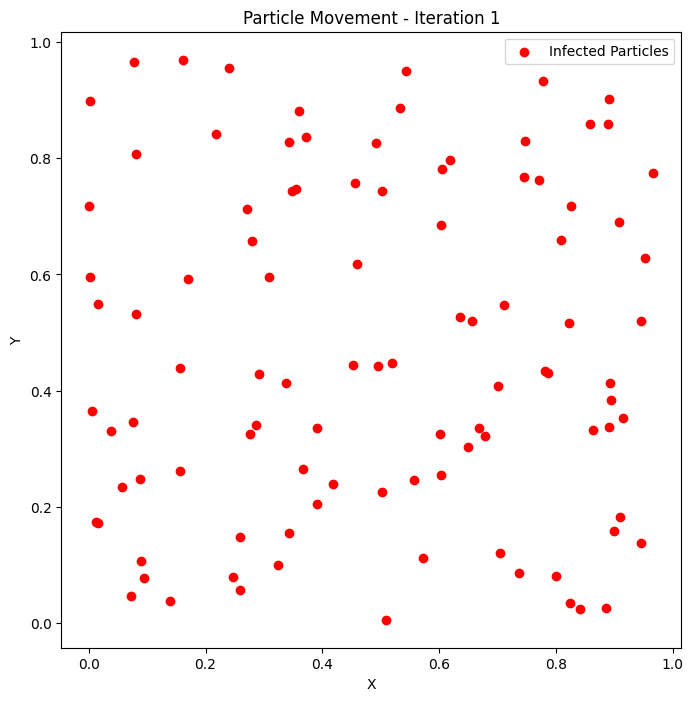

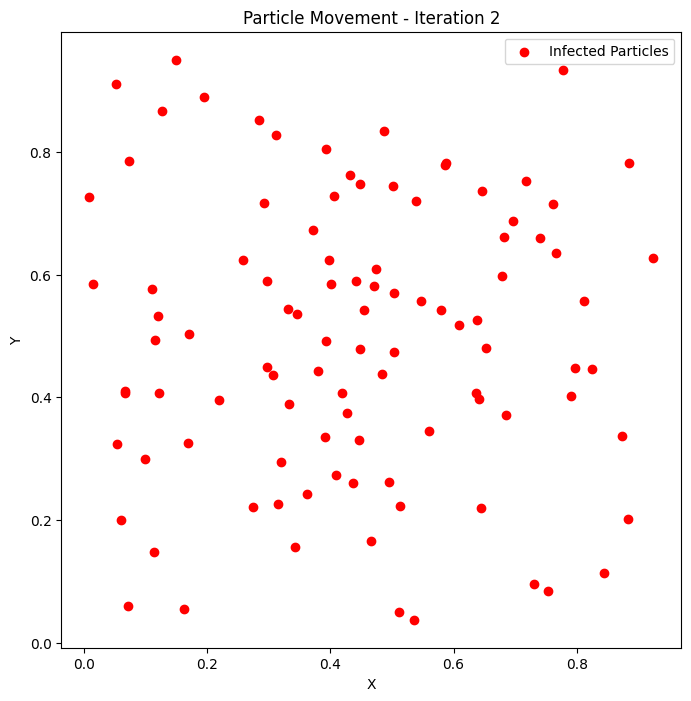

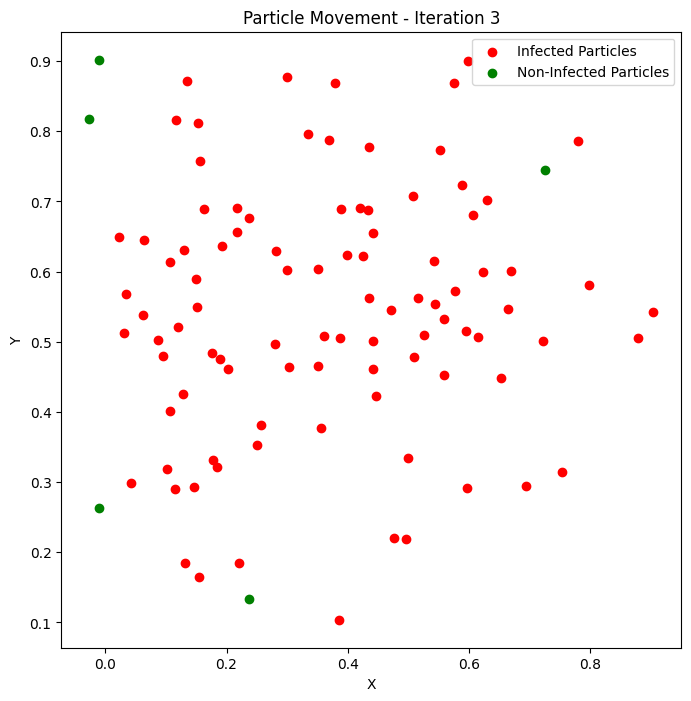

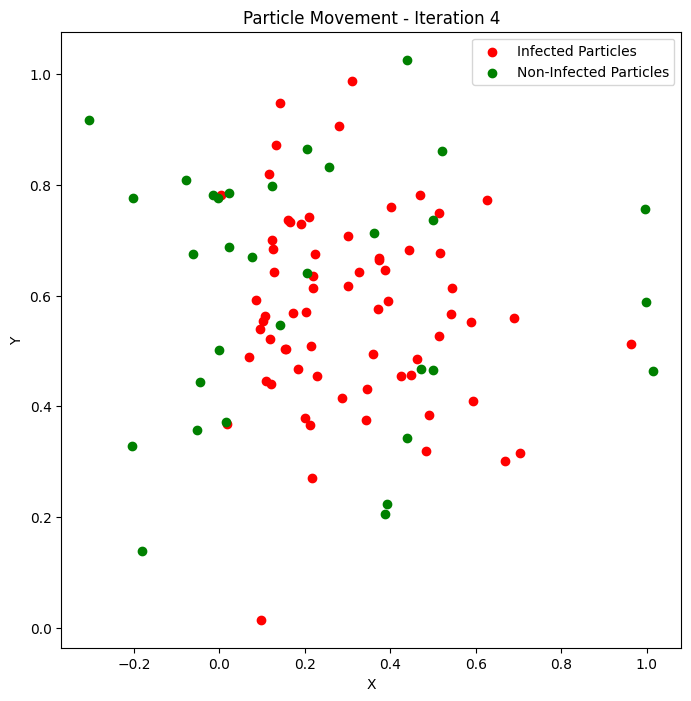

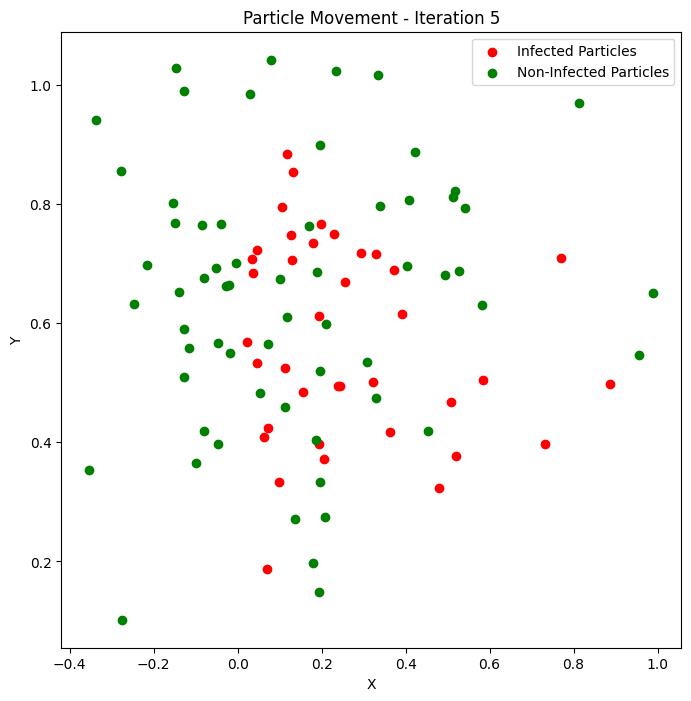

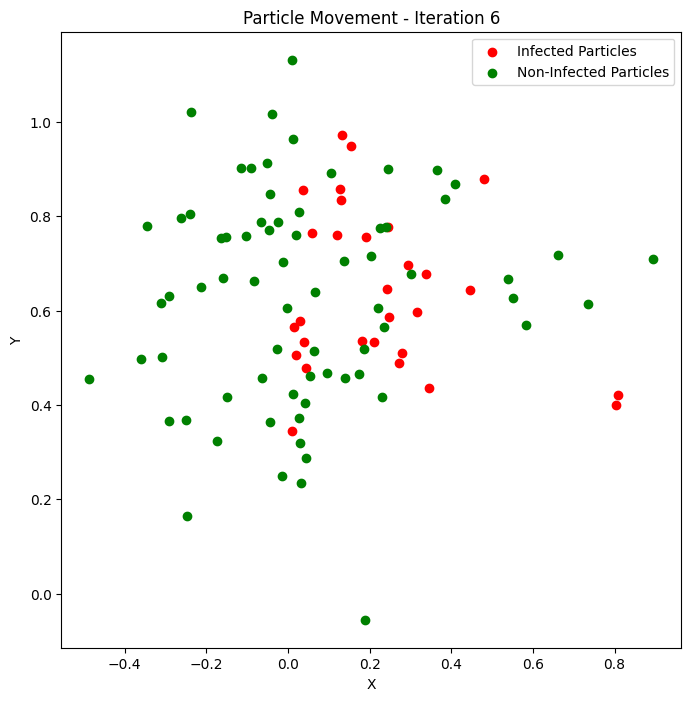

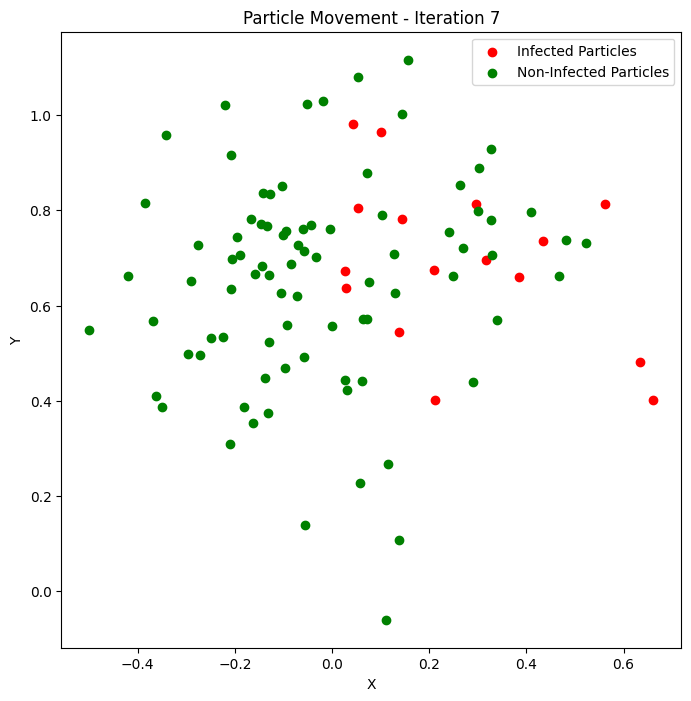

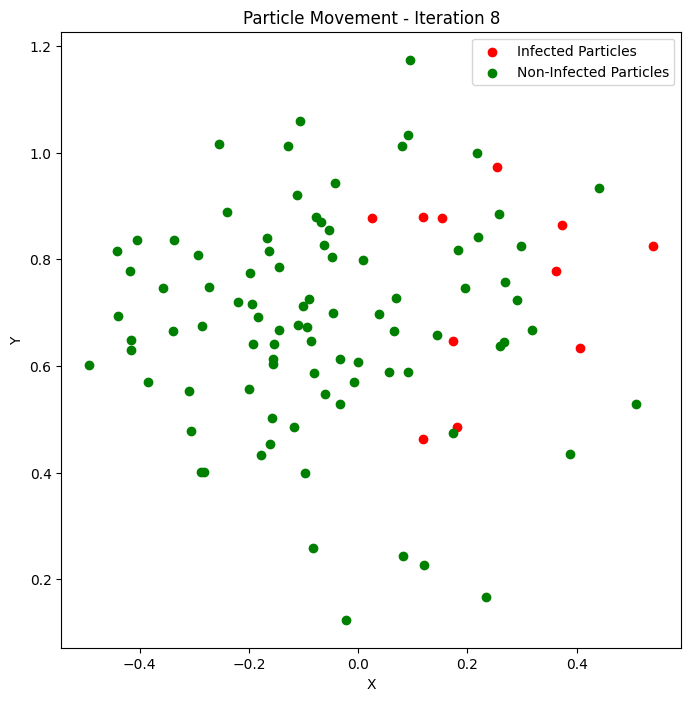

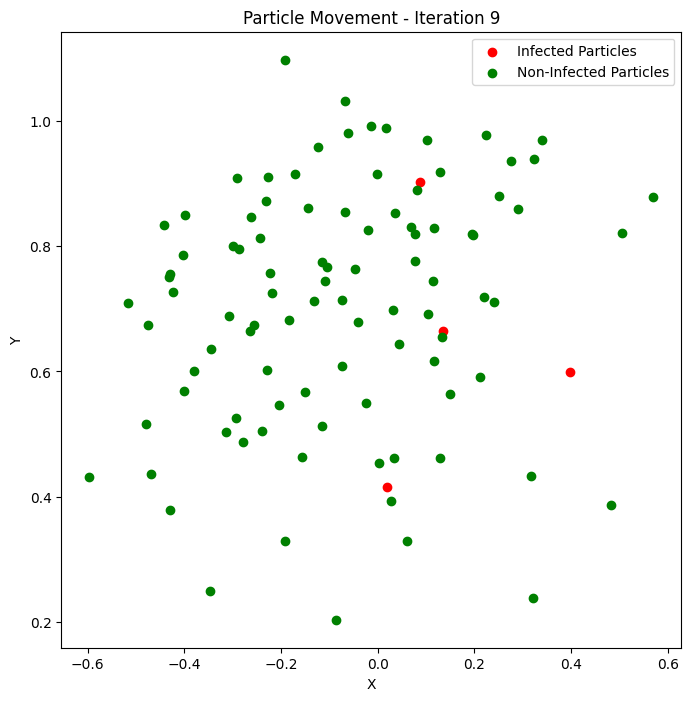

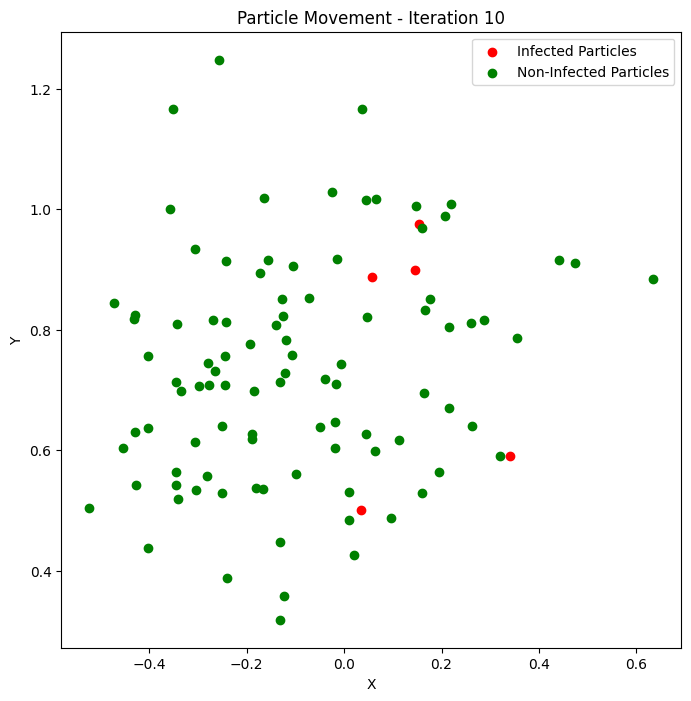

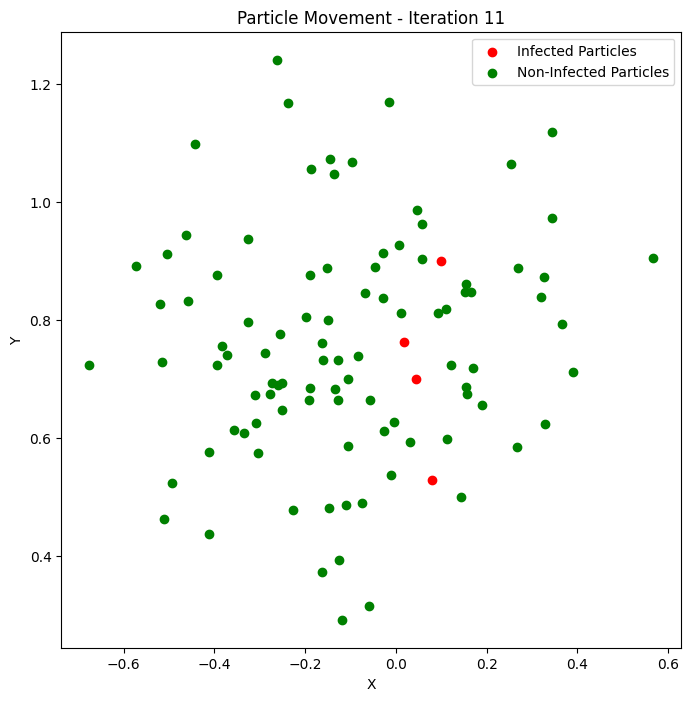

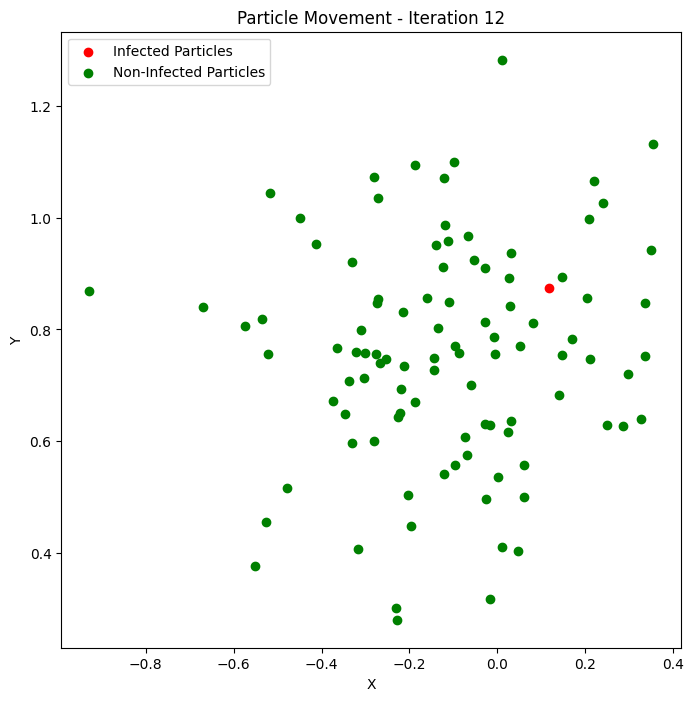

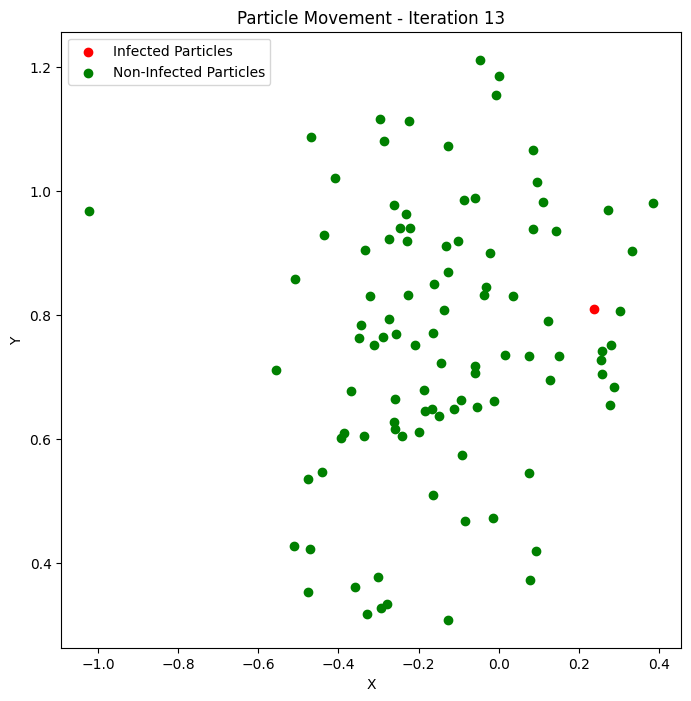

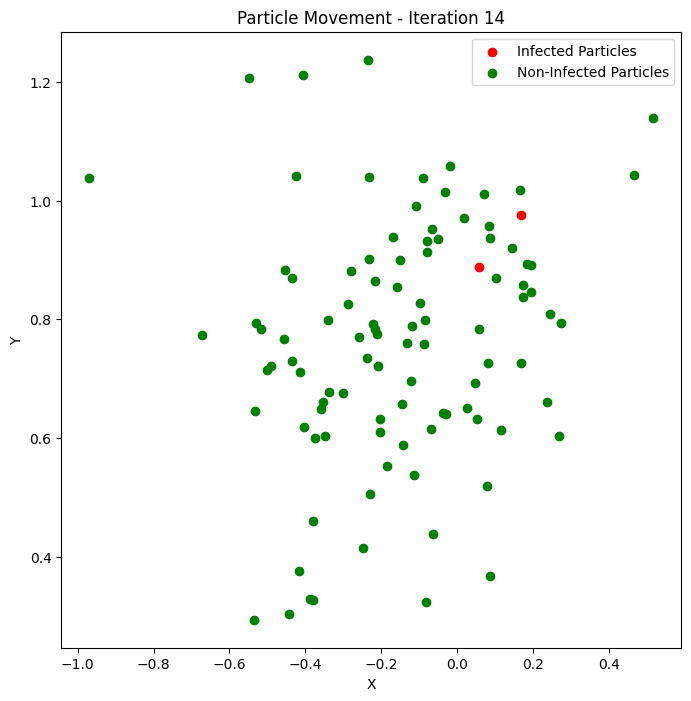

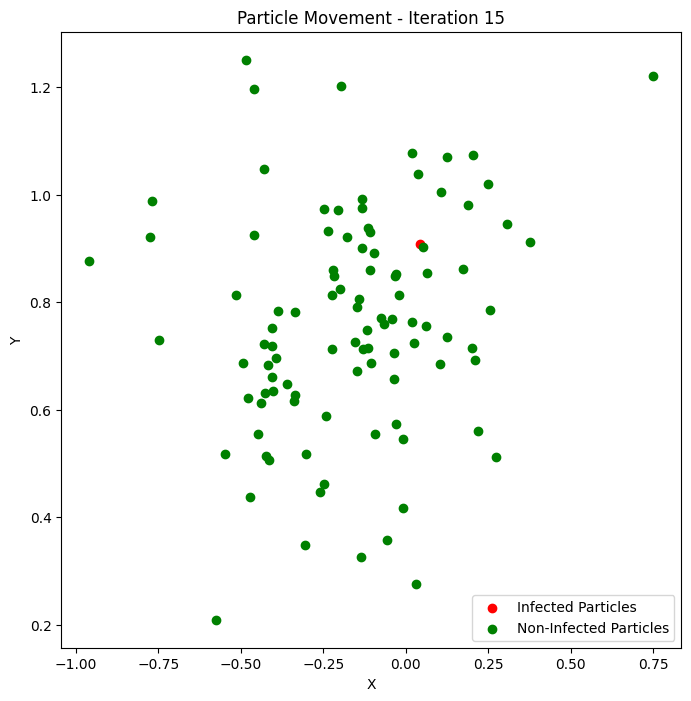

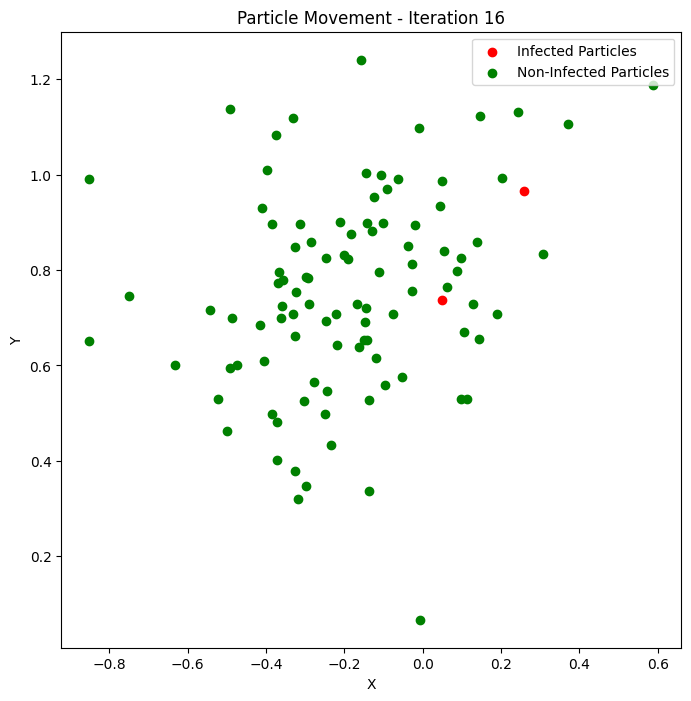

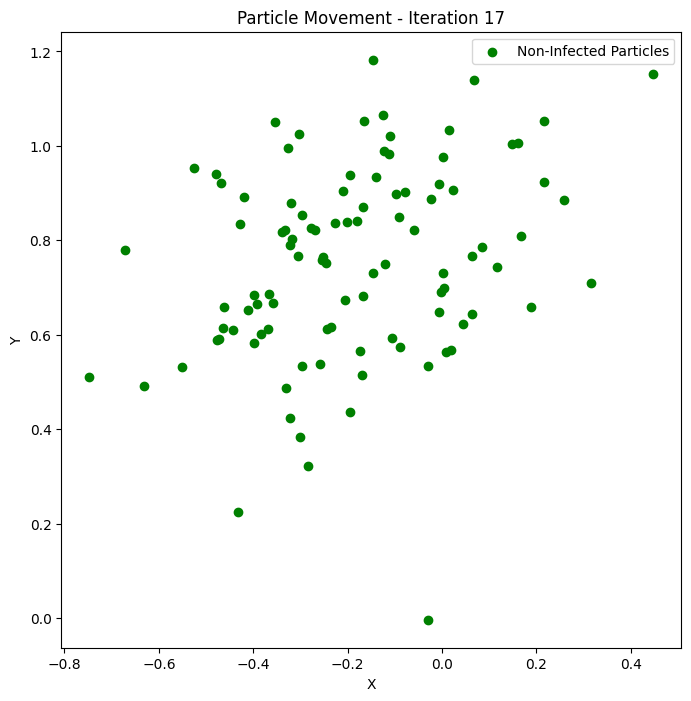

In [234]:
import matplotlib.pyplot as plt

# Function to plot particle movement on a map with different colors for infected and non-infected particles
def plot_particle_movement(iteration, swarm):
    plt.figure(figsize=(8, 8))
    plt.title(f'Particle Movement - Iteration {iteration}')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Separate infected and non-infected particles
    infected_particles = [particle for particle in swarm if particle.assess_fitness() > 0]
    non_infected_particles = [particle for particle in swarm if particle.assess_fitness() == 0]

    # Plot positions of infected particles in red
    if infected_particles:
        infected_x = [particle.position[0] for particle in infected_particles]
        infected_y = [particle.position[1] for particle in infected_particles]
        plt.scatter(infected_x, infected_y, color='red', label='Infected Particles')

    # Plot positions of non-infected particles in green
    if non_infected_particles:
        non_infected_x = [particle.position[0] for particle in non_infected_particles]
        non_infected_y = [particle.position[1] for particle in non_infected_particles]
        plt.scatter(non_infected_x, non_infected_y, color='green', label='Non-Infected Particles')

    # Show legend
    plt.legend()


# Initialize PSO
pso = PSO(problem, swarm_size, vector_length, num_informants)

# Flag to track if all particles become non-infected
all_particles_non_infected_flag = False

# Run iterations
for i in range(num_iterations):
    # Improve PSO for the next iteration
    pso.improve(follow_current, follow_personal_best, follow_social_best, follow_global_best, scale_update_step)

    # Plot particle movement at each iteration
    plot_particle_movement(i+1, pso.swarm)

    # Check if all particles are non-infected
    if not any(particle.assess_fitness() > 0 for particle in pso.swarm):
        all_particles_non_infected_flag = True
        print(f"All particles are non-infected after {i+1} iterations.")
        break

# If all particles never become non-infected, print a message
if not all_particles_non_infected_flag:
    print("All particles are not non-infected within the given number of iterations.")

##9) Animation

This code segment utilizes Matplotlib to create an animated visualization depicting the movement of particles on a map throughout the iterations of the Particle Swarm Optimization (PSO) algorithm. Here's a breakdown:

1. **Plotting Function:** Defines a function `plot_particle_movement(iteration, swarm)` to plot the movement of particles on the XY plane. Similar to the previous code, it separates particles into infected (red) and non-infected (green) categories based on their fitness assessments.

2. **PSO Initialization:** Initializes the PSO algorithm with the defined problem, swarm size, vector length, and number of informants.

3. **Animation Update Function:** Defines a function `update_plot(frame)` to update the plot for each iteration of the animation. This function improves the PSO for the next iteration, plots the particle movement, and checks if all particles become non-infected.

4. **Animation Creation:** Utilizes Matplotlib's `FuncAnimation` class to create the animation. It specifies the number of frames (iterations) and the interval between frames.

5. **Displaying the Animation:** Finally, it displays the animation using the `HTML` class from IPython's display module, converting the animation to HTML format for rendering in a Jupyter Notebook environment.

This segment provides an interactive and dynamic visualization of particle movement during PSO optimization, allowing for a deeper understanding of the algorithm's behavior and convergence properties.

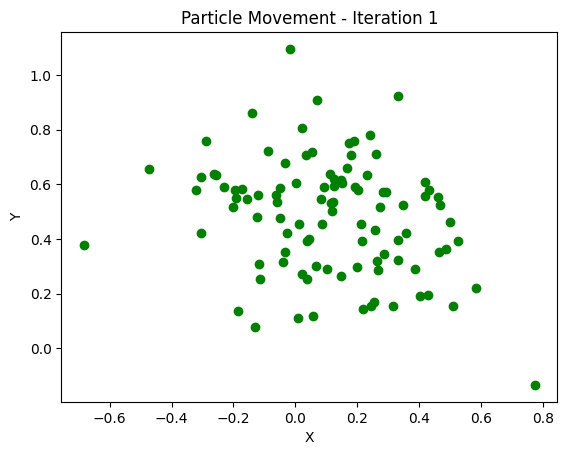

In [233]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Function to plot particle movement on a map with different colors for infected and non-infected particles
def plot_particle_movement(iteration, swarm):
    plt.clf()  # Clear the previous plot
    plt.title(f'Particle Movement - Iteration {iteration}')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Separate infected and non-infected particles
    infected_particles = [particle for particle in swarm if particle.assess_fitness() > 0]
    non_infected_particles = [particle for particle in swarm if particle.assess_fitness() == 0]

    # Plot positions of infected particles in red
    if infected_particles:
        infected_x = [particle.position[0] for particle in infected_particles]
        infected_y = [particle.position[1] for particle in infected_particles]
        plt.scatter(infected_x, infected_y, color='red', label='Infected Particles')

    # Plot positions of non-infected particles in green
    if non_infected_particles:
        non_infected_x = [particle.position[0] for particle in non_infected_particles]
        non_infected_y = [particle.position[1] for particle in non_infected_particles]
        plt.scatter(non_infected_x, non_infected_y, color='green', label='Non-Infected Particles')

# Initialize PSO
pso = PSO(problem, swarm_size, vector_length, num_informants)

# Flag to track if all particles become non-infected
all_particles_non_infected_flag = False

# Function to update the plot for each iteration
def update_plot(frame):
    iteration = frame + 1
    # Improve PSO for the next iteration
    pso.improve(follow_current, follow_personal_best, follow_social_best, follow_global_best, scale_update_step)
    # Plot particle movement at each iteration
    plot_particle_movement(iteration, pso.swarm)
    # Check if all particles are non-infected
    if not any(particle.assess_fitness() > 0 for particle in pso.swarm):
        global all_particles_non_infected_flag
        all_particles_non_infected_flag = True
    return []

# Create the animation
animation = FuncAnimation(plt.gcf(), update_plot, frames=num_iterations, interval=500)

# Display the animation
from IPython.display import HTML
HTML(animation.to_jshtml())